## Adaptive data retrieval demo

In [90]:
from app.dataprocessing.data_handler import DataHandler
from app.dataprocessing.benchmark import Timer, Plot, Benchmark
from dotenv import load_dotenv
import os
import numpy as np

### Example 1: Copernicus dataset with 3 dimensions accessed via OPeNDAP

In [91]:
"""
Copernicus uses CAS SSO for authentication.
user credentials are saved in .env file.
"""

load_dotenv()
USERNAME = os.environ.get('CMEMS_CAS_USERNAME')
PASSWORD = os.environ.get('CMEMS_CAS_PASSWORD')

cas_url = 'https://cmems-cas.cls.fr/cas/login'

dataset_url = 'https://nrt.cmems-du.eu/thredds/dodsC/METEOFRANCE-EUR-SST-L4-NRT-OBS_FULL_TIME_SERIE'

##### Create DataHandler instance, this class is directly mapped to the API endpoints

In [92]:
# Create a DataHandler object, one instance per dataset is required
data_handler = DataHandler()

# Establish connection to the remote data source
data_handler.set_opendap_cas(cas_url, dataset_url, USERNAME, PASSWORD)

# Set the maximum chunk size in MB. keep in mind that the client can possibly work with multiple chunks simoultaneously to increase interactivity. This is a design choice front-end.
data_handler.set_max_chunk_size(50)

# Show the auto-selected data structure
print(f'Data structure in use: {data_handler.data_structure}')

Data structure in use: Octree with 4096 chunks of maximum size 50MB


##### Display meta data

In [93]:
print(f'data set total size: {data_handler.data_source.file_size_MB} MB')
print(data_handler.ds)

data set total size: 27817 MB
<xarray.Dataset>
Dimensions:           (lat: 2500, lon: 4750, time: 409)
Coordinates:
  * lat               (lat) float32 20.01 20.03 20.05 ... 69.95 69.97 69.99
  * lon               (lon) float32 -39.99 -39.97 -39.95 ... 54.95 54.97 54.99
  * time              (time) datetime64[ns] 2020-11-18 2020-11-19 ... 2022-01-01
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
Attributes: (12/50)
    title:                      Euro SST, L4, 0.02deg daily, MeteoFrance
    myocean_id:                 SST_EUR_SST_L4_NRT_OBSERVATIONS_010_009_c
    summary:                    A merged, multi-sensor L4 subskin SST product...
    processing_level:           L4
    product_id:                 SST_EUR_L4_NRT_OBSERVATIONS_010_018
    Conventions:                CF-1.4
    ...                         ...
  

##### Request the inital dataset and render

Finished 'Get inital dataset from server' in 38.3763 seconds
File size: 38.67 MB


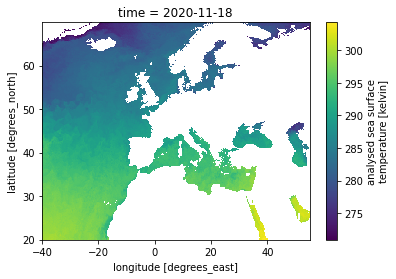

In [94]:
with Timer('Get inital dataset from server'):
    file_name = data_handler.get_inital_netcdf()
print(f'File size: {Benchmark.get_file_size_MB(file_name):.2f} MB')

Plot.netcdf_color_contour(data_variable='analysed_sst', netcdf_file=file_name)


##### The initial dataset equals the "root" chunk in the data structure. After requesting it from the server it is cached locally. The next request for this particular chunk will take advantage of the cache.

Finished 'Get inital dataset from local cache' in 0.4258 seconds
File size: 38.67 MB


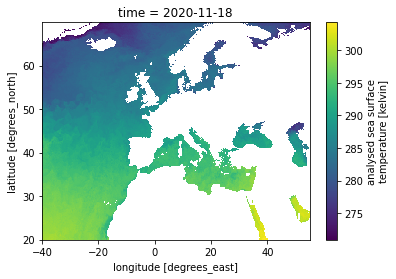

In [95]:
with Timer('Get inital dataset from local cache'):
    file_name = data_handler.get_inital_netcdf()
print(f'File size: {Benchmark.get_file_size_MB(file_name):.2f} MB')

Plot.netcdf_color_contour(data_variable='analysed_sst', netcdf_file=file_name)

##### Next step is to query area of interest e.g. the Black Sea at 2020-11-18

[<app.datastructures.three_dimensional.octree.Cube object at 0x7feaf95c2610>, <app.datastructures.three_dimensional.octree.Cube object at 0x7feb0613e310>]
Finished 'Fetch the chunk covering the Black Sea' in 0.0625 seconds
File size: 0.07 MB


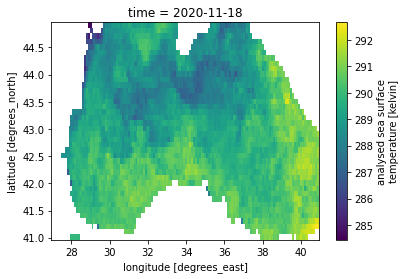

In [111]:
query_bounds = ((41,46), (27,41), (np.datetime64('2020-11-18'), np.datetime64('2020-11-19')))

with Timer('Fetch the chunk covering the Black Sea'):
    file_name = data_handler.request_data_netcdf(query_bounds)
print(f'File size: {Benchmark.get_file_size_MB(file_name):.2f} MB')

Plot.netcdf_color_contour(data_variable='analysed_sst', netcdf_file=file_name)

### Example 2: QuadTree on 7,5GB local dataset

In [112]:
from app.dataprocessing.local.local_netcdf_reader import LocalNetcdfReader
from app.datastructures.two_dimensional.quad_tree import QuadTree

r = LocalNetcdfReader(2)
tree = QuadTree(max_chunk_size=50, original_file_size=7470,
                dataset=r.get_dataset())

##### Requst inital dataset and render